In [1]:
import countingworkspace
from countingworkspace import create_workspace, create_variables
import countingworkspace.utils
import ROOT

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

countingworkspace.utils.silence_roofit()

Welcome to JupyROOT 6.14/08


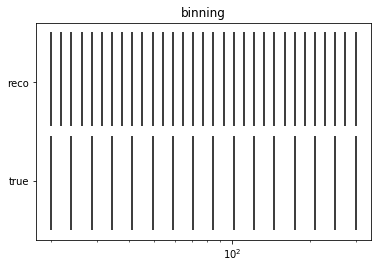

In [2]:
XMIN = 20
XMAX = 300
NBINS_TRUE = 15

xtrue_edges = np.logspace(np.log10(XMIN), np.log10(XMAX), NBINS_TRUE + 1)
xtrue_centers = 0.5 * (xtrue_edges[1:] + xtrue_edges[:-1])
xtrue_widths = np.diff(xtrue_edges)

xreco_edges = np.logspace(np.log10(XMIN), np.log10(XMAX), 2 * NBINS_TRUE + 1)
xreco_centers = 0.5 * (xreco_edges[1:] + xreco_edges[:-1])
xreco_widths = np.diff(xreco_edges)

NBINS_RECO = len(xreco_edges) - 1

fig, ax = plt.subplots()
ax.vlines(xtrue_edges, 0, 0.95)
ax.vlines(xreco_edges, 1.05, 2)
ax.set_xscale('log')

ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(['true', 'reco'])
ax.set_title('binning')

plt.show()

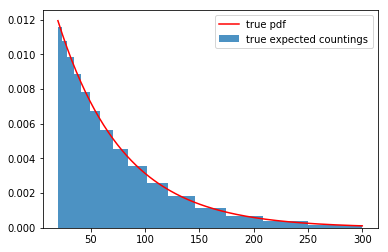

In [3]:
true_pdf = stats.expon(scale=60)

ntrue = np.diff(true_pdf.cdf(xtrue_edges))

x = np.linspace(XMIN, XMAX, 200)

fig, ax = plt.subplots()

ax.plot(x, (true_pdf.pdf(x)), 'r', label='true pdf')
ax.bar(xtrue_edges[:-1], ntrue / xtrue_widths, width=xtrue_widths, align='edge', alpha=0.8, label='true expected countings')
ax.legend()
plt.show()

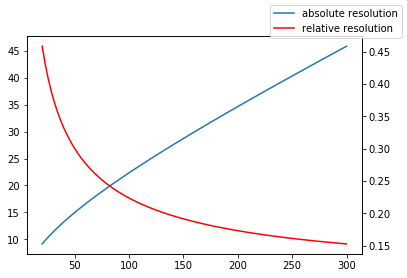

In [4]:
def qsum(x):
    x = np.asarray(x)
    return np.sqrt(np.sum(x ** 2))

def get_resolution(xtrue):
    return qsum([2. / np.sqrt(xtrue), 0.1])  * xtrue  # random numbers

x = np.linspace(XMIN, XMAX, 100)

fig, ax = plt.subplots()

ax.plot(x, get_resolution(x), label='absolute resolution')
ax2 = ax.twinx()
ax2.plot(x, get_resolution(x) / x, 'r', label='relative resolution')
fig.legend()

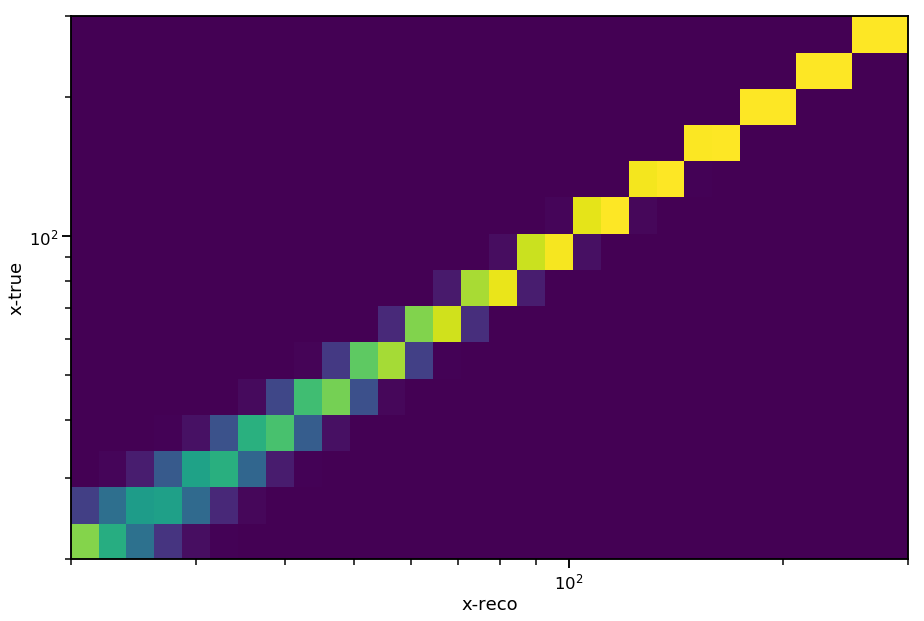

In [5]:


migration_matrix = np.zeros([NBINS_TRUE, NBINS_RECO])
for true_bin in range(NBINS_TRUE):
    for reco_bin in range(NBINS_RECO):
        xtrue = xtrue_centers[true_bin]
        xreco = xreco_centers[reco_bin]
        resolution = get_resolution(xreco)  # nevermind if this is reco
        migration_matrix[true_bin][reco_bin] = np.exp(-(xreco - xtrue) ** 2 / (2 * resolution))

migration_matrix = migration_matrix / migration_matrix.sum(axis=0)

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.pcolormesh(xreco_edges, xtrue_edges, migration_matrix)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('x-reco')
    ax.set_ylabel('x-true')

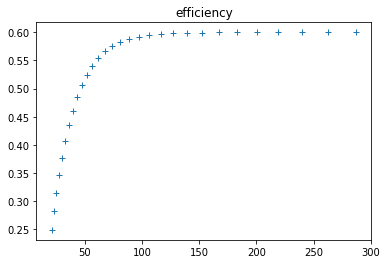

In [6]:
def get_efficiency(xreco):
    return 0.60 - np.exp(-xreco / 20.)

efficiency = get_efficiency(xreco_centers)
fig, ax = plt.subplots()
ax.plot(xreco_centers, efficiency, '+')
ax.set_title('efficiency')
plt.show()

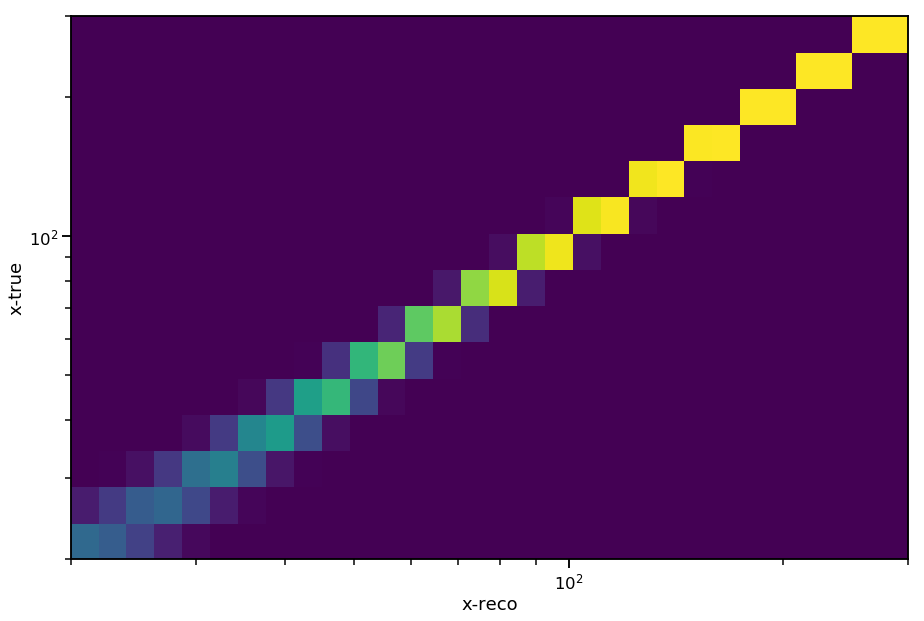

In [7]:
folding_matrix = migration_matrix * efficiency

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.pcolormesh(xreco_edges, xtrue_edges, folding_matrix)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('x-reco')
    ax.set_ylabel('x-true')

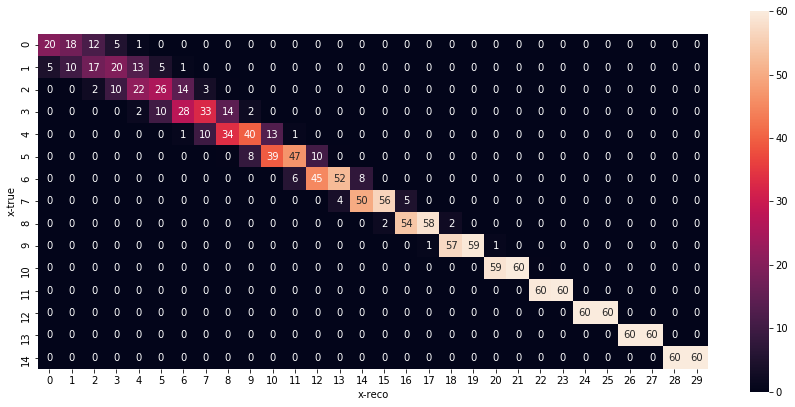

In [8]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(folding_matrix * 100, annot=True, square=True, ax=ax, fmt='.0f')
ax.set_xlabel('x-reco')
ax.set_ylabel('x-true')
plt.show()

In [9]:
def create_toy(nevents, randomize_nevents=False):
    if randomize_nevents:
        nevents = np.random.poisson(nevents)
    toy_true_xvalues = true_pdf.rvs(nevents)
    resolutions = get_resolution(toy_true_xvalues)
    smearing = np.random.normal(1, resolutions, size=nevents)
    toy_reco_xvalues = toy_true_xvalues + smearing
    toy_ispass = np.random.uniform(0, 1, size=nevents) < get_efficiency(toy_reco_xvalues)
    toy_reco_xvalues = np.where(toy_ispass, toy_reco_xvalues, np.nan)
    return toy_true_xvalues, toy_reco_xvalues, toy_ispass

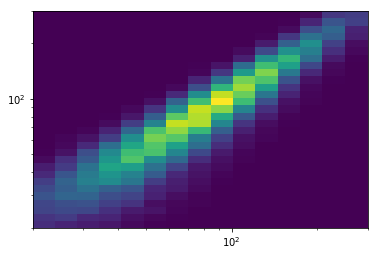

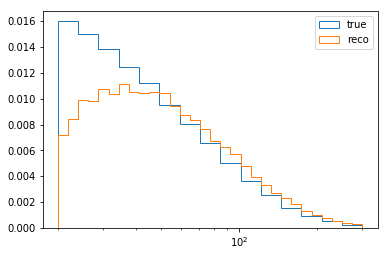

In [10]:
toy_true_xvalues, toy_reco_xvalues, toy_ispass = create_toy(100000)

fig, ax = plt.subplots()
ax.hist2d(toy_true_xvalues[toy_ispass], toy_reco_xvalues[toy_ispass], bins=[xtrue_edges, xreco_edges])
ax.set_xscale('log')
ax.set_yscale('log')

fig, ax = plt.subplots()
ax.hist(toy_true_xvalues, bins=xtrue_edges, histtype='step', density=True, label='true')
ax.hist(toy_reco_xvalues, bins=xreco_edges, histtype='step', density=True, label='reco')
ax.legend()
ax.set_xscale('log')
plt.show()

In [11]:
ws = create_workspace(["reco_bin_%03d" % b for b in range(NBINS_RECO)],
                      ["true_bin_%03d" % b for b in range(NBINS_TRUE)],
                      nsignal_gen=ntrue * 1000, nexpected_bkg_cat=[0] * NBINS_RECO,
                      efficiencies=folding_matrix.T)

INFO:root:adding observables for 30 categories
INFO:root:adding efficiencies for 30 categories and 15 processes
INFO:root:adding expected events for 30 categories and 15 processes


In [12]:
pdf = ws.obj('ModelConfig').GetPdf()
obs = ws.obj('ModelConfig').GetObservables()
#toy_data = ROOT.RooStats.AsymptoticCalculator.GenerateAsimovData(pdf, obs)
toy_data = pdf.generate(obs, 1)
toy_reco = [x.getVal() for x in countingworkspace.utils.iter_collection(toy_data.get())]

In [13]:
fit_result = pdf.fitTo(toy_data, ROOT.RooFit.Save())

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nsignal_gen_proctrue_bin_000   4.57329e+01  5.02287e+03   -1.00000e+04  5.00000e+04
     2 nsignal_gen_proctrue_bin_001   5.09557e+01  5.02548e+03   -1.00000e+04  5.00000e+04
     3 nsignal_gen_proctrue_bin_002   5.59684e+01  5.02798e+03   -1.00000e+04  5.00000e+04
     4 nsignal_gen_proctrue_bin_003   6.04302e+01  5.03022e+03   -1.00000e+04  5.00000e+04
     5 nsignal_gen_proctrue_bin_004   6.39234e+01  5.03196e+03   -1.00000e+04  5.00000e+04
     6 nsignal_gen_proctrue_bin_005   6.59789e+01  5.03299e+03   -1.00000e+04  5.00000e+04
     7 nsignal_gen_proctrue_bin_006   6.61288e+01  5.03306e+03   -1.00000e+04  5.00000e+04
     8 nsignal_gen_proctrue_bin_007   6.39893e+01  5.03199e+03   -1.00000e+04  5.00000e+04
     9 nsignal_gen_proctrue_bin_008   5.93683e+01  5.02968e+03   -1.00000e+04  5.00000e+0

In [14]:
ntrue_fitted = [x.getVal() for x in countingworkspace.utils.iter_collection(fit_result.floatParsFinal())]
ntrue_fittted_error = [x.getError() for x in countingworkspace.utils.iter_collection(fit_result.floatParsFinal())]

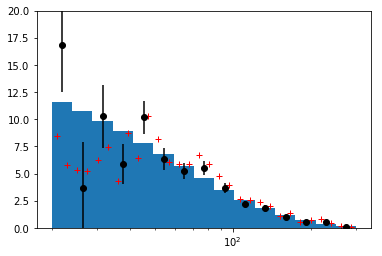

In [15]:
fig, ax = plt.subplots()
ax.bar(xtrue_edges[:-1], ntrue * 1000 / xtrue_widths, width=xtrue_widths, align='edge', label='true')
ax.errorbar(xtrue_centers, ntrue_fitted / xtrue_widths, ntrue_fittted_error / xtrue_widths, marker='o', ls='', color='k')
ax.plot(xreco_centers, toy_reco / xreco_widths, 'r+')
ax.set_ylim(0, 20)
ax.set_xscale('log')

In [16]:
#toy_reco = np.random.poisson(np.matmul(folding_matrix.T, ntrue * 1000))

In [17]:
ntrue_fitted_chi2 = np.linalg.lstsq(folding_matrix.T, toy_reco)[0]

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


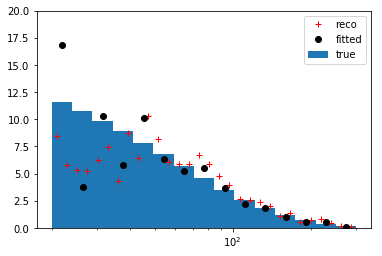

In [18]:
fig, ax = plt.subplots()
ax.bar(xtrue_edges[:-1], ntrue * 1000 / xtrue_widths, width=xtrue_widths, align='edge', label='true')
ax.plot(xreco_centers, toy_reco / xreco_widths, marker='+', ls='', color='r', label='reco')
ax.plot(xtrue_centers, ntrue_fitted_chi2 / xtrue_widths, marker='o', ls='', color='k', label='fitted')
ax.set_xscale('log')
ax.set_ylim(0, 20)
ax.legend()